## __The Movie Lens Dataset__

In [38]:
import pandas as pd
import numpy as np
from numpy import random
import scipy
import scipy.sparse
data_dir = "data/"
data_shape = (943, 1682)
df = pd.read_csv(data_dir + "u.data", sep="\t", header=None)
values = df.values

In [39]:
df.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       100000 non-null  int64
 1   1       100000 non-null  int64
 2   2       100000 non-null  int64
 3   3       100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [41]:
df.describe()

,0,1,2,3
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


It is preferable to begin with the MovieLens 100K Dataset for many reasons:
- It is a stable dataset (Released 4/1998)
- It's reasonable size will make life easier for our computer while doing calculations (calculations on bigger datasets might take more time and require more power capacity)

The __*df*__ differs from the rating matrix __*values*__ since the latter is a mathematical tool without column names, just containing the values of the initial dataframe.

## __Data Preprocessing__

In [42]:
 M = scipy.sparse.csr_matrix((values[:, 2], (values[:, 0]-1, values[:, 1]-1)), dtype=float, shape=
     data_shape)

In a sparse matrix, the missing values are implicitly coded as zeros.

In [43]:
# We will extract the non-zero indices to schuffle the corresponding lines and create our train/test data matrices:

rows, cols = M.nonzero() # the indices
data = M.data # the values

n_nonzeros = len(data)
indices = np.arange(n_nonzeros)
np.random.shuffle(indices) # we schuffle randomly the indices

# We create the train/test matrices, using 90% for training and 10 % for testing:
train_size = int(0.9*n_nonzeros)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

M_train = scipy.sparse.csr_matrix((data[train_indices],
                      (rows[train_indices], cols[train_indices])),
                     shape=M.shape)

M_test = scipy.sparse.csr_matrix((data[test_indices],
                     (rows[test_indices], cols[test_indices])),
                    shape=M.shape)


In [44]:
M_train

<943x1682 sparse matrix of type '<class 'numpy.float64'>'
	with 90000 stored elements in Compressed Sparse Row format>

In [45]:
M_test

<943x1682 sparse matrix of type '<class 'numpy.float64'>'
	with 10000 stored elements in Compressed Sparse Row format>

In [52]:
# We will compute the global mean of ratings given by the users to the movies:

global_mean = M_train.sum() / n_nonzeros # We compute the global mean on the train data, to then center and compute the test error

print(f"The global mean of the ratings given by the users if {mean:.1f}.")

The global mean of the ratings given by the users if 3.5.


In [60]:
# We center the data:
M_train_centered = M_train.copy()
M_train_centered.data -= global_mean

# We compute the test error when predicting missing values by the mean:
test_data = M_test.data
test_predictions = np.full(test_data.shape, global_mean)

test_error = np.mean((test_data - test_predictions)**2)
print(f"The test error when predicting missing values is {test_error:.1f}.")

The test error when predicting missing values is 1.4.


The test error is quite high, knowing the ranking vary from 0 to 5.

## __Recommending using SVD__

In [61]:
M_train_centered.shape

(943, 1682)

In [64]:
# We compute the 20 first factors of the SVD of the centered training data:
k = 20  # Number of factors
U, S, Vt = scipy.sparse.linalg.svds(M_train_centered, k=k)

# We sort the values in the descending order:
U, S, Vt = U[:, ::-1], S[::-1], Vt[::-1, :]

print("The 20 first factors of the SVD of the centered training data are:", S)

The 20 first factors of the SVD of the centered training data are: [116.55631993  60.79185499  53.55184091  45.79110955  43.5894206
  39.38393386  38.3368326   36.38139767  33.63239693  33.3742132
  32.13609166  30.67181126  30.06734815  28.87872289  28.69232607
  28.49670936  27.87719778  27.70596551  27.2333393   26.92482414]


Number of factors: 1, MSE: 1.16
Number of factors: 2, MSE: 1.12
Number of factors: 3, MSE: 1.11
Number of factors: 4, MSE: 1.09
Number of factors: 5, MSE: 1.07
Number of factors: 6, MSE: 1.06
Number of factors: 7, MSE: 1.06
Number of factors: 8, MSE: 1.05
Number of factors: 9, MSE: 1.05
Number of factors: 10, MSE: 1.04
Number of factors: 11, MSE: 1.04
Number of factors: 12, MSE: 1.04
Number of factors: 13, MSE: 1.04
Number of factors: 14, MSE: 1.04
Number of factors: 15, MSE: 1.04
Number of factors: 16, MSE: 1.04
Number of factors: 17, MSE: 1.04
Number of factors: 18, MSE: 1.04
Number of factors: 19, MSE: 1.04
Number of factors: 20, MSE: 1.05


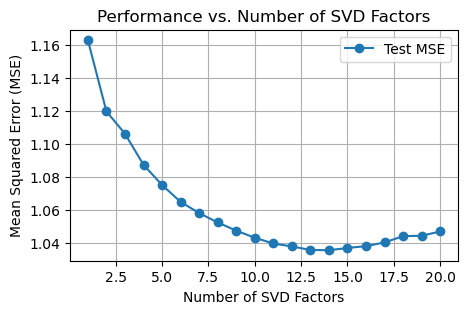

In [70]:
# We will predict the missing test values using the SVD 
# with an increasing number of component (up to 20):

def svd_predict(M_train_centered, M_test, k):
    U, S, Vt = scipy.sparse.linalg.svds(M_train_centered, k=k)
    
    U, S, Vt = U[:, ::-1], S[::-1], Vt[::-1, :] 

    # We reconstruct the matrix with k components:
    S_matrix = np.diag(S)
    M_reconstructed = U @ S_matrix @ Vt
    
    # We add back the global mean to get predictions:
    M_predicted = M_reconstructed + global_mean
    
    # We extract the predictions for the test set:
    test_rows, test_cols = M_test.nonzero()
    test_values = M_test.data
    pred_values = M_predicted[test_rows, test_cols]
    
    # We compute the MSE:
    mse = np.mean((test_values - pred_values) ** 2)
    return mse


# We will evaluate the performance of this approach on the test matrix 
# and plot the resulting performance as a function of the number of factors 
# of the SVD used to perform the reconstruction:
import matplotlib.pyplot as plt

max_components = 20
mses = []

for k in range(1, max_components + 1):
    mse = svd_predict(M_train_centered, M_test, k)
    mses.append(mse)
    print(f"Number of factors: {k}, MSE: {mse:.2f}")

# Plot the results
plt.figure(figsize=(5, 3))
plt.plot(range(1, max_components + 1), mses, marker='o', label='Test MSE')
plt.xlabel('Number of SVD Factors')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Performance vs. Number of SVD Factors')
plt.grid()
plt.legend()
plt.show()

We wan see that the more we keep information, i.e. we keep a large number of factors of the SVD, the better the prediction is (the MSE decreases as the number of factors increases).

## __Recommending using the weighted SVD__